In [1]:
import numpy as np
from IPython.display import Audio
import soundfile as sf
import scipy
import math
import matplotlib.pyplot as plt
from scipy import fft,fftpack,signal
import pandas as pd
import torch

In [2]:
def getsounds_dif_linear_nonorm(m1,m2,x1,x2,h,tau11,w11,p,D,l0,alpha_side,sr):
    """
    This implements Rabenstein's drum model. The inverse SLT operation is done at the end of each second-
    -order filter, no normalization on length and side length ratio is done
    """
    l2 = l0*alpha_side
    beta_side = alpha_side + 1/alpha_side
    S = l0/np.pi*((D*w11*alpha_side)**2 + (p*alpha_side/tau11)**2)**0.25
    c_sq = (alpha_side*(1/beta_side-p**2*beta_side)/tau11**2 + alpha_side*w11**2*(1/beta_side-D**2*beta_side))*(l0/np.pi)**2
    T = c_sq 
    d1 = 2*(1-p*beta_side)/tau11
    d3 = -2*p*alpha_side/tau11*(l0/np.pi)**2 

    EI = S**4 
        
    mu = np.arange(1,m1+1) #(0,1,2,..,m-1)
    mu2 = np.arange(1,m2+1)
    dur = 2**16
    Ts = 1/sr
    tau = 1/sr*np.arange(1,dur+1)

    n = (mu*np.pi/l0)**2+(mu2*np.pi/l2)**2 #eta 
    n2 = n**2 #(mu*np.pi/l0)**4+(mu2*np.pi/l2)**4 
    K = np.sin(mu*math.pi*x1)*np.sin(mu2*math.pi*x2) #mu pi x / l
    
    beta = EI*n2 + T*n #(m,1)
    alpha = (d1-d3*n)/2 # nonlinear
    omega = np.sqrt(np.abs(beta - alpha**2))
    print(omega,w11)
    mode_corr = np.sum(omega <= sr/2)
    print("corected partials",omega[:mode_corr],mode_corr)
    beta = beta[:mode_corr]
    alpha = alpha[:mode_corr]
    omega = omega[:mode_corr]
    mu = mu[:mode_corr]
    mu2 = mu2[:mode_corr]
    K = K[:mode_corr]
    
    N = l0*l2/4
    c0 = -np.exp(-2*alpha*Ts)
    c1 = 2*np.exp(-alpha*Ts)*np.cos(omega*Ts)
    a1 = 1 #term a1 neither

    a0 = np.exp(-alpha*Ts)*np.sin(omega*Ts)/omega
    #o_a = mu*math.pi*x1
    #o_a2 = mu2*math.pi*x2
    
    #derive mu domain of the plucked string yx extended to 2D

    #yi = (h/(mu*math.pi)*np.cos(o_a)-h/(mu*math.pi)**2/x1*np.sin(o_a)-2*h/(1-x1)/(mu*math.pi)*np.cos(mu*math.pi) + \
    # h*x1/(1-x1)/(mu*math.pi)*np.cos(o_a)-h/(1-x1)/(mu*math.pi)**2*np.sin(o_a)+h/(1-x1)/(mu*math.pi)*np.cos(o_a)) \
    #*(h/(mu2*math.pi)*np.cos(o_a2)-h/(mu2*math.pi)**2/x1*np.sin(o_a2)-2*h/(1-x2)/(mu2*math.pi)*np.cos(mu2*math.pi) + \
    # h*x2/(1-x2)/(mu2*math.pi)*np.cos(o_a2)-h/(1-x2)/(mu2*math.pi)**2*np.sin(o_a2)+h/(1-x2)/(mu2*math.pi)*np.cos(o_a2))
    
    yi = h*np.sin(mu*np.pi*x1)*np.sin(mu2*np.pi*x2)
     
    y_i = np.zeros(c0.shape)
    y_ii = np.zeros(c0.shape)
    y = []
    summed = 0
    node1 = 0
    node2 = a1*yi+node1
    dur_excit = 1
    for i in range(dur):
        #signal forward pass
        y.append(np.sum(node2*K/N)) #sum over all mode

        #update
        y_ii = y_i
        y_i = node2  #continuing with excitation
        if i<dur_excit: #calculated for the current sample, but manifest in the next loop
            node1 = a0*yi+c0*y_ii+c1*y_i
        elif i>=dur_excit:
            a1 = 0
            node1 = c0*y_ii+c1*y_i


        node2 = node1
      
    return y


In [3]:
def getsounds_imp_linear_nonorm(m1,m2,x1,x2,h,tau11,w11,p,D,l0,alpha_side,sr):
    l2 = l0*alpha_side
    beta_side = alpha_side + 1/alpha_side
    S = l0/np.pi*((D*w11*alpha_side)**2 + (p*alpha_side/tau11)**2)**0.25
    c_sq = (alpha_side*(1/beta_side-p**2*beta_side)/tau11**2 + alpha_side*w11**2*(1/beta_side-D**2*beta_side))*(l0/np.pi)**2
    T = c_sq 
    d1 = 2*(1-p*beta_side)/tau11
    d3 = -2*p*alpha_side/tau11*(l0/np.pi)**2 

    EI = S**4 

    mu = np.arange(1,m1+1) #(0,1,2,..,m-1)
    mu2 = np.arange(1,m2+1)
    dur = 2**16
    Ts = 1/sr
    tau = 1/sr*np.arange(1,dur+1)

    n = (mu*np.pi/l0)**2+(mu2*np.pi/l2)**2 #eta 
    n2 = n**2 #(mu*np.pi/l0)**4+(mu2*np.pi/l2)**4 
    K = np.sin(mu*math.pi*x1)*np.sin(mu2*math.pi*x2) #mu pi x / l

    beta = EI*n2 + T*n #(m,1)
    alpha = (d1-d3*n)/2 # nonlinear
    omega = np.sqrt(np.abs(beta - alpha**2))
    #print(omega,w11)
    #check if modal frequency exceeds nyquist
    mode_corr = np.sum(omega <= sr/2)
    print("corected partials",omega[:mode_corr],mode_corr)
    
    
    N = l0*l2/4
    yi = h*np.sin(mu[:mode_corr] * np.pi * x1)*np.sin(mu2[:mode_corr] * np.pi * x2) / omega[:mode_corr]


    time_steps = np.linspace(0,dur,dur)/sr
    y = np.exp(-alpha[:mode_corr,None]*time_steps[None,:])*np.sin(omega[:mode_corr,None]*time_steps[None,:]) 
    y = yi[:,None]*y #(m,) * (m,dur)
    y = np.sum(y*K[:mode_corr,None]/N,axis=0) #impulse response itself

    return y

In [4]:
omega,tau,p,D,alpha = [2340.097525980212,0.7045670759992748,2.684021733917418e-05,
                       0.2590482257247541,0.3358646872293123]
omega_pert = omega*np.logspace(np.log10(0.5),np.log10(2),100)[33]
sr = 22050
N = 2**16

In [5]:
m = 10
y = getsounds_imp_linear_nonorm(m,m,0.4,0.4,0.03,tau,omega_pert,p,0,np.pi,alpha,sr)

Audio(y,rate=sr)

corected partials [1857.33663722 3714.67408775 5572.01135753 7429.34858214 9286.68578867] 5


In [6]:
m = 10
y = getsounds_dif_linear_nonorm(m,m,0.4,0.4,0.03,tau,omega_pert,p,0,np.pi,alpha,sr)

Audio(y,rate=sr)

[ 1857.33663722  3714.67408775  5572.01135753  7429.34858214
  9286.68578867 11144.02298617 13001.3601785  14858.6973676
 16716.03455455 18573.37174   ] 1857.3366372245848
corected partials [1857.33663722 3714.67408775 5572.01135753 7429.34858214 9286.68578867] 5


In [54]:
m = 10
ffts_imp = []
#ffts_filt = []
allwav_imp = np.array([])
for d_o in np.logspace(np.log10(0.5),np.log10(2),50):
    print(d_o)
    omega_pert = omega*d_o #d_o
    #synthesize perturbed audio
    wavform = getsounds_imp_linear_nonorm(10,10,0.4,0.4,0.03,tau,
                                                omega_pert,p,D,np.pi,alpha,sr)
    wavform = wavform/ max(wavform)
    allwav_imp = np.concatenate((allwav_imp,wavform[:wavform.shape[0]//4]))
    fft_ref = 2/N * np.abs(scipy.fft.fft(wavform)[:N//2])
    ffts_imp.append(fft_ref)
    
ffts_imp = np.stack(ffts_imp)

0.5
corected partials [1170.04876299 4192.6292445  9215.94314943] 3
0.5143478667381387
corected partials [1203.62417045 4312.93977509 9480.40134831] 3
0.5291074560361481
corected partials [1238.16304885 4436.70270573 9752.44837056] 3
0.5442905825748725
corected partials [ 1273.6930457   4564.01710555 10032.30198299] 3
0.5599094000660888
corected partials [ 1310.24260187  4694.98488654 10320.1862014 ] 3
0.5759764109812476
corected partials [ 1347.84097436  4829.7108851  10616.33146989] 3
0.5925044765593883
corected partials [ 1386.51825973  4968.30294603 10920.9748453 ] 3
0.6095068271022377
corected partials [1426.30541817 5110.87200878] 2
0.626997072564735
corected partials [1467.23429831 5257.53219633] 2
0.6449892134494587
corected partials [1509.33766268 5408.40090646] 2
0.6634976520136782
corected partials [1552.64921397 5563.59890579] 2
0.6825372037979984
corected partials [1597.203622   5723.25042643] 2
0.7021231094858295
corected partials [1643.03655144 5887.48326541] 2
0.7222710

In [28]:
Audio(allwav_imp,rate=sr) #mode 3

In [55]:
m = 10
ffts = []
#ffts_filt = []
allwav = np.array([])
for d_o in np.logspace(np.log10(0.5),np.log10(2),50):
    print(d_o)
    omega_pert = omega*d_o #d_o
    #synthesize perturbed audio
    wavform = getsounds_dif_linear_nonorm(10,10,0.4,0.4,0.03,tau,
                                                omega_pert,p,D,np.pi,alpha,sr)
    wavform = wavform/ max(wavform)
    allwav = np.concatenate((allwav,wavform[:wavform.shape[0]//4]))
    fft_ref = 2/N * np.abs(scipy.fft.fft(wavform)[:N//2])
    ffts.append(fft_ref)
ffts = np.stack(ffts)   

0.5
[  1170.04876299   4192.6292445    9215.94314943  16246.40902185
  25284.96146836  36331.84163738  49387.13374574  64450.87332717
  81523.07745931 100603.75517181] 1170.048762990106
corected partials [1170.04876299 4192.6292445  9215.94314943] 3
0.5143478667381387
[  1203.62417045   4312.93977509   9480.40134831  16712.61159247
  26010.53192952  37374.41042681  50804.33371748  66300.33835477
  83862.44190633 103490.65366085] 1203.6241704471183
corected partials [1203.62417045 4312.93977509 9480.40134831] 3
0.5291074560361481
[  1238.16304885   4436.70270573   9752.44837056  17192.19218927
  26756.92316876  38446.89649388  52262.20128343  68202.87513944
  86268.93613357 106460.39382107] 1238.163048847874
corected partials [1238.16304885 4436.70270573 9752.44837056] 3
0.5442905825748725
[  1273.6930457    4564.01710555  10032.30198299  17685.53470449
  27524.73265354  39550.15833678  53761.90343     70160.00661411
  88744.4864793  109515.35285495] 1273.6930456977875
corected partials

1.2718590309757472
[  2976.27417178  10664.86518662  23442.75916713  41326.28207115
  64317.81112714  92417.95971061 125626.94203214 163944.84847389
 207371.72247384 255907.58699947] 2976.274171781936
corected partials [ 2976.27417178 10664.86518662] 2
1.3083559587480234
[  3061.68054217  10970.90129955  24115.46631669  42512.17002635
  66163.45787176  95069.96082931 129231.89925636 168649.3661286
 213322.40613049 263251.04288851] 3061.680542167718
corected partials [ 3061.68054217 10970.90129955] 2
1.3459001926323562
[  3149.537711    11285.71934365  24807.47729187  43732.08790681
  68062.06680404  97798.06306588 132940.30337289 173488.88336868
 219443.84901995 270805.22463116] 3149.5377109952674
corected partials [3149.537711] 1
1.3845217858458045
[  3239.91600572  11609.57132288  25519.34603008  44987.0122262
  70015.1577128  100604.45019772 136755.12286615 178467.27410623
 225740.95120366 278576.17916033] 3239.916005723472
corected partials [3239.91600572] 1
1.4242516540045351
[  3

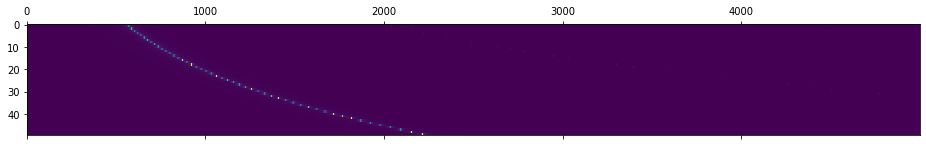

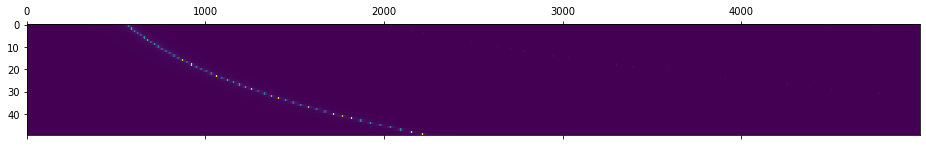

In [56]:
plt.matshow(ffts[:,:5000],aspect="auto")
plt.matshow(ffts_imp[:,:5000],aspect="auto")

sanity checks with features

In [7]:
def load_jtfs(fold_str, idx_reduced):
    csv_path = "../notebooks/" + fold_str + "_param_v2.csv"
    df = pd.read_csv(csv_path)
    sample_ids = df.values[:, 0]
    y = df.values[:,1:-1]
    ba = 1/y[:,-1] + 1/y[:,-1]**2
    y_ba = np.hstack((y, ba[:,None]))
    
    jtfs_set = []
    num = 0
    for i in sample_ids:
        wav_path = os.path.join(feature_path,"jtfs_j"+str(J)+"_q"+str(Q)+"_f"+str(F),
                                fold_str,
                                fold_str+"_"+str(i)+".npy")
        if os.path.exists(wav_path):
            jtfs_wav = np.load(wav_path)
            jtfs_set.append(jtfs_wav.squeeze()[idx_reduced])
            num += 1

    jtfs_set = np.stack(jtfs_set)
    jtfs_set = np.maximum(0,jtfs_set.squeeze())
    #mulogscale jtfs
    if fold_str == "test":
        #mulog
        mu = np.mean(jtfs_set,axis=0)
        jtfs_set = np.log1p(jtfs_set/eps/mu[None,:])
        return jtfs_set,y_ba,mu
    else:
        mu = np.mean(jtfs_set,axis=0)
        jtfs_set = np.log1p(jtfs_set/eps/mu[None,:])
        return jtfs_set,y_ba
def compute_numcoef(jtfs):
    num = 0
    wav = np.random.random(N,)
    Sw_list = jtfs(wav)
    for i in Sw_list:
        if len(i['j']) == 1:
            num += 1
    return num


In [4]:
import os
from kymatio.torch import TimeFrequencyScattering1D

J = 14
Q = 12
F = 24
N = 2**16
eps = 0.1
#compute nearest neighbor graph of jtfs features of the entire test set
fold = "test"
feature_path = "/home/han/data/drum_data/han2022features-pkl/"
feat_path = "/home/han/data/drum_data/han2022features-pkl/jtfs_j14_q16/"
model_path = "/home/han/wave2shape/output/doce"
audio_path = "/home/han/data/drum_data/"
num_dim = 1000
sr = 22050


In [10]:
#standarization based on training set
fold_jtfs, y_fold = load_jtfs("train",slice(None)) #means loading full features
mu_train = np.mean(fold_jtfs,axis=0)#not reduced
std_train = np.std(fold_jtfs,axis=0)
print("compute standardization parameters")

compute standardization parameters


In [11]:
#initialize jtfs instance
params = dict(J = J, #scale
        shape = (N, ), 
        T = N, 
        average = True,
        max_pad_factor=1,
        max_pad_factor_fr=1)

## when frequential averaging is true, make jtfs this way:
# initialize jtfs (global averaging) and two octaves of frequential averaging
jtfs = TimeFrequencyScattering1D(**params, average_fr = True, Q = Q, F = F).cuda() #same as JTFS models similarity paper
jtfs_q1 = TimeFrequencyScattering1D(**params, average_fr = False, Q = 1).cuda()
#compute number of coef
jtfs_list = TimeFrequencyScattering1D(**params, average_fr = True, out_type = "list", Q = Q, F = F).cuda()
num_jtfs = compute_numcoef(jtfs_list)
jtfs_q1_list = TimeFrequencyScattering1D(**params, average_fr = False, out_type = "list", Q = 1).cuda()
num_jtfs_q1 = compute_numcoef(jtfs_q1_list)

In [12]:
import sys
sys.path.append("../src")
import running_var

mean_fold, var_fold, sampvar_fold = running_var.welford(os.path.join(feature_path,
                                                                     "jtfs_j"+str(J)+"_q"+str(Q)+"_f"+str(F),
                                                                     fold))
idx_fold = np.flip(np.argsort(sampvar_fold))[:num_dim]

In [13]:
fold = "test"
reduced_fold_jtfs, y_fold, mu_fold = load_jtfs(fold,idx_fold)
reduced_fold_jtfs = (reduced_fold_jtfs - mu_train[None,idx_fold]) / std_train[None,idx_fold]
print("finished loading features with reduced dimensionality and standardize " + fold)

finished loading features with reduced dimensionality and standardize test


In [38]:
omega = 100
#synthesize perturbed audio
wavform = getsounds_imp_linear_nonorm(10,10,0.4,0.4,0.03,tau,
                                            omega,p,D,np.pi,alpha,sr)
wavform = wavform/ max(wavform)

#compute jtfs
#jtfs_wav = jtfs(np.array(wavform))/np.linalg.norm(wavform,ord=2)
jtfs_wav = jtfs(wavform)/np.linalg.norm(wavform,ord=2)
jtfs_wav_q1 = jtfs_q1(wavform)/np.linalg.norm(wavform,ord=2)
#concatenation
jtfs_comb = torch.concat((jtfs_wav_q1[:,:num_jtfs_q1,:],jtfs_wav[:,num_jtfs:,:]),dim=1)
#apply dimensionality reduction
jtfs_wav_ref = jtfs_comb.squeeze()[list(idx_fold)]
jtfs_wav_ref = np.maximum(0,jtfs_wav_ref.cpu().squeeze())
#mulog
jtfs_wav_ref = np.log1p(jtfs_wav_ref/eps/mu_fold)
#standardize
jtfs_wav_ref = (jtfs_wav_ref - mu_train[idx_fold]) / std_train[idx_fold]

corected partials [ 100.          358.33781497  787.66477447 1388.53489651 2161.02885378
 3105.16746208 4220.95799101 5508.40350791 6967.50548691 8598.26470749] 10


In [39]:
from scipy.spatial.distance import cosine

In [40]:
euc_dists = []
cos_dists = []
allwav = np.array([])
ffts = []
for d_o in np.logspace(np.log10(0.25),np.log10(4),100):
    print(d_o)
    omega_pert = omega*d_o #d_o
    #synthesize perturbed audio
    wavform = getsounds_imp_linear_nonorm(10,10,0.4,0.4,0.03,tau,
                                                omega_pert,p,D,np.pi,alpha,sr)
    wavform = wavform/ max(wavform)
    allwav = np.concatenate((allwav,wavform[:wavform.shape[0]//2]))
    fft_ref = 2/N * np.abs(scipy.fft.fft(wavform)[:N//2])
    ffts.append(fft_ref)
    #compute jtfs
    jtfs_wav = jtfs(wavform)/np.linalg.norm(wavform,ord=2)
    jtfs_wav_q1 = jtfs_q1(wavform)/np.linalg.norm(wavform,ord=2)
    #concatenation
    jtfs_comb = torch.concat((jtfs_wav_q1[:,:num_jtfs_q1,:],jtfs_wav[:,num_jtfs:,:]),dim=1)
    #apply dimensionality reduction
    jtfs_wav_red = jtfs_comb.squeeze()[list(idx_fold)]
    jtfs_wav_red = np.maximum(0,jtfs_wav_red.cpu().squeeze())
    #mulog
    jtfs_wav_red = np.log1p(jtfs_wav_red/eps/mu_fold)
    #standardize
    jtfs_wav_red = (jtfs_wav_red - mu_train[idx_fold]) / std_train[idx_fold]

    #compute naive euclidean distance
    dist = np.linalg.norm(jtfs_wav_red - jtfs_wav_ref, ord=2)
    cos_dists.append(cosine(jtfs_wav_red.ravel(), jtfs_wav_ref.ravel()))
    euc_dists.append(dist)

0.25
corected partials [  25.           89.61606424  196.95454541  347.17451737  540.29915197
  776.3344303  1055.28244158 1377.14406739 1741.91973146 2149.60965785] 10
0.25710044999730297
corected partials [  25.710045     92.15943324  202.54611756  357.03246116  555.64211452
  798.38118218 1085.25179641 1416.25485699 1791.39079639 2210.65984328] 10
0.2644025655552627
corected partials [  26.44025656   94.77509061  208.29656368  367.17045559  571.42091403
  821.05417172 1116.07240572 1456.47653469 1842.26700016 2273.44403561] 10
0.2719120743387978
corected partials [  27.19120743   97.46508805  214.21039434  377.59645276  587.64792712
  844.37118327 1147.76844471 1497.84064973 1894.58824927 2338.01148179] 10
0.27963486668882004
corected partials [  27.96348667  100.23153554  220.29224825  388.31863065  604.33588203
  868.35050632 1180.36477527 1540.37964748 1948.39558369 2404.4128275 ] 10
0.28757700024252586
corected partials [  28.75770002  103.07660305  226.54689592  399.34539957  6

0.8815912549960212
corected partials [  88.1591255   315.90961468  694.40096191 1224.12297133 1905.14696573
 2737.49134848 3721.16254673 4856.16327231 6142.49482855 7580.15790458] 10
0.9066300334926564
corected partials [  90.66300335  324.88148065  714.12254921 1258.88957585 1959.25585813
 2815.24030896 3826.84953341 4994.08631841 6316.95200337 7795.44729648] 10
0.9323799583681275
corected partials [  93.23799584  334.10817855  734.40428305 1294.6436336  2014.9015601
 2895.19749978 3935.53824086 5135.9266475  6496.36409627 8016.85131499] 10
0.9588612274596487
corected partials [  95.88612275  343.59694566  755.26207208 1331.41318952 2072.12771925
 2977.42563811 4047.31392277 5281.7955169  6680.87183527 8244.54362592] 10
0.9860946122593678
corected partials [  98.60946123  353.35522483  776.71227683 1369.22708506 2130.97922288
 3061.98922242 4162.26425425 5431.80734387 6870.61994537 8478.70282758] 10
1.0141014742071979
corected partials [ 101.41014742  363.3906703   798.77172252 1408.1

3.889530337307812
corected partials [ 388.95303373 1393.73517713 3063.60888272 5400.70908762 8405.34666125] 5
4.0
corected partials [ 400.         1433.31964344 3150.62074214 5554.09879024 8644.07347488] 5


Text(0.5, 1.0, "euclidean distance of 100 pitched drum sounds' concat JTFS perturbed around 2000hz")

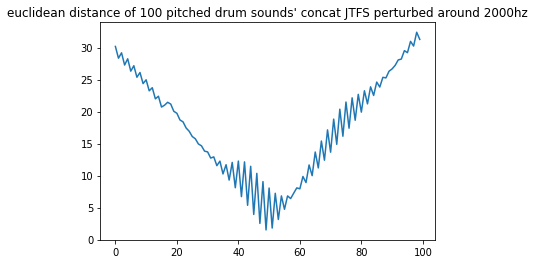

In [36]:
plt.plot(euc_dists)
plt.title("euclidean distance of 100 pitched drum sounds' concat JTFS perturbed around 2000hz")

Text(0.5, 1.0, "cosine distance of 100 pitched drum sounds' concat JTFS perturbed around 100hz")

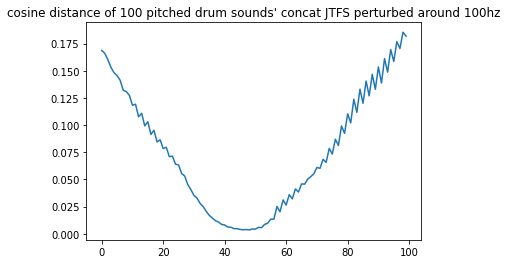

In [41]:
plt.plot(cos_dists)
plt.title("cosine distance of 100 pitched drum sounds' concat JTFS perturbed around 100hz")

In [5]:
#load random sounds from train set
csv_path = "../notebooks/train_param_v2.csv"
df = pd.read_csv(csv_path)
sample_ids = df.values[:, 0]
ffts = []
N = 2**16
for i in sample_ids[:500]:
    wav_path = os.path.join(audio_path,"train", str(i) + "_sound.wav")
    wav, sr = sf.read(wav_path)
    fft_wav = 2/N * np.abs(scipy.fft.fft(wav)[:N//2])
    ffts.append(fft_wav)
ffts = np.stack(ffts)

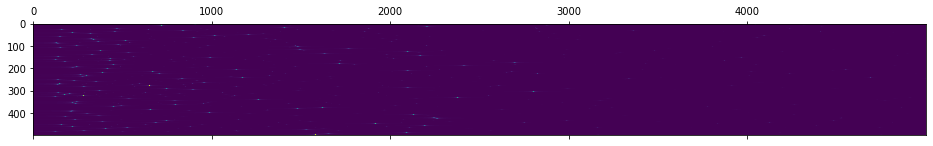

In [6]:
plt.matshow(ffts[:,:5000],aspect="auto")

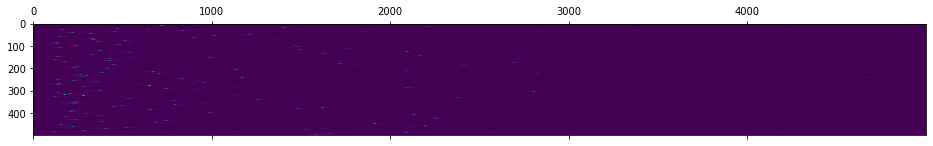

In [46]:
plt.matshow(ffts[:,:5000],aspect="auto")

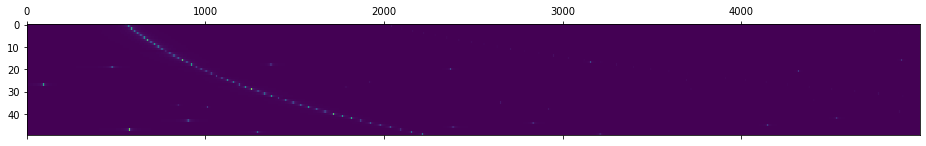

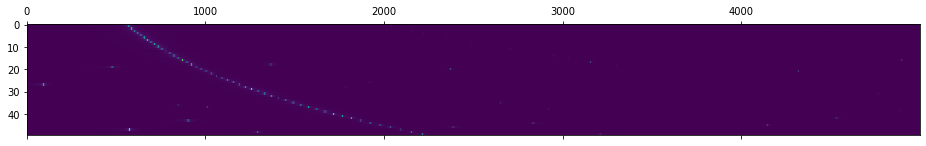

In [43]:
plt.matshow(ffts[:,:5000],aspect="auto")
plt.matshow(ffts_filt[:,:5000],aspect="auto")